# Read output files

In [20]:
import awkward as ak
import numpy as np
import pandas as pd
import os, uproot, yaml, gc
from glob import glob
from scipy.interpolate import CubicSpline, interp1d
if 'postprocess' not in os.getcwd():
    os.chdir('postprocess')

In [21]:
source = 'glopart_v2'
base = f'/data/bond/fudawei/public/bbgamma_output/{source}'

filepath = {
    year: {
        #'data': sum([glob(f'{base}/data/{year}/{channel}/*') for channel in ['SingleMuon']], []),
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in filepath['2018'].keys()]) - set(['data'])

for year in filepath:
    for job_dir in sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['ZpToHG', 'GluGluToZG']], []):
        mass = job_dir.split('M')[1].replace('_0p014', '')
        filepath[year][mass+r'$\to$'+('H' if 'ZpToHG' in job_dir else 'Z')+r'$\gamma$'] = [job_dir]

events = {year: {k: [] for k in filepath[year]} for year in filepath}

for year in filepath:
    for channel, folders in filepath[year].items():
        for folder in folders:
            mode = '_'.join(folder.split('/')[-4:-1])
            if len(os.listdir(folder)) != 2:
                continue
            if os.path.exists(os.path.join(folder, f'{mode}.parq')):
                os.rename(os.path.join(folder, f'{mode}.parq'), os.path.join(folder, f'{mode}.parquet'))
            folder_events = ak.from_parquet(os.path.join(folder, f'{mode}.parquet'))
            folder_events = folder_events[folder_events.photon_pt > 225]
            with open(os.path.join(folder, f'{mode}.yaml'), 'r', encoding='utf-8') as f:
                folder_stats = yaml.safe_load(f)
            if 'mc' in mode and ak.mean(folder_events.event_final_weight) > np.sqrt(folder_stats['final']):
                test_events = folder_events
                continue

            events[year][channel].append(folder_events)

        if len(events[year][channel]) == 0:
            del events[year][channel]
        else:
            events[year][channel] = ak.concatenate(events[year][channel], axis=0)

In [22]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'1000$\to$Z(bb)$\gamma$': 'blue',
    r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'2000$\to$Z(bb)$\gamma$': 'cyan',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

In [23]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal.gen_HWW_decay_mode, 0)

    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)

    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)
    
    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    for y in events:
        for c in list(events[y].keys()):
            if c in BKG or c=='data':
                continue
            if 'H' in c:
                events[y][c.replace('H', 'H(bb)')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
            if 'Z' in c:
                events[y][c.replace('Z', 'Z(bb)')] = events[y][c][events[y][c]['gen_GluGluToZ(bb)Gamma']]


In [24]:
weight = {y: {c: events[y][c].event_final_weight for c in events[y]} for y in events}


gc.collect()
weight['2016'] = {k: ak.concatenate([weight[y][k] for y in ['2016pre', '2016post']], axis=0) for k in weight['2016pre']}
events['2016'] = {k: ak.concatenate([events[y][k] for y in ['2016pre', '2016post']], axis=0) for k in events['2016pre']}

In [25]:
gc.collect()

weight['Run2'] = {k: ak.concatenate([weight[y][k] for y in ['2016', '2017', '2018']], axis=0) for k in weight['2018']}

In [26]:
gc.collect()

events['Run2'] = {k: ak.concatenate([events[y][k] for y in ['2016', '2017', '2018']], axis=0) for k in events['2018']}

# Start plotting

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])

    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

# Uncertainty

In [28]:
index = pd.MultiIndex.from_product(
    [range(700, 3501, 50), ['SRH1_N', 'SRH2_N', 'SRZ1_N', 'SRZ2_N', 'SRZ1_W', 'SRZ2_W', 'SRZ1_VW', 'SRZ2_VW']],
    names=['mass', 'region']
)
df=pd.read_csv('../src/parameters/uncertainty/systematics.csv', index_col=[0,1])

In [37]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for m in MASS:
    print(df['JES'][m, 'SRH1_N'] == df['JES'][m, 'SRH2_N'])
    print(df['JES'][m, 'SRZ1_N'] == df['JES'][m, 'SRZ2_N'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [36]:
df.to_csv('../src/parameters/uncertainty/systematics.csv')

In [31]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def uncertainty_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(loc=1, data=False, year=year, ax=ax, lumi=round(LUMI[year]), fontsize=18)


    ## analyze
    individual = {'h': {}, 'var': {}}
    ratio = {}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        
        if weight is not None:
            hist.fill(v, weight=weight[k])
        else:
            hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio[k] = h / individual['h']['nominal']
        #ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio[k], bins=hist.axes[0].edges, yerr=0, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(ax1.get_ylim()[0]*1.2-0.2, ax1.get_ylim()[1]*1.2-0.2)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

    if 'up' in ratio and 'down' in ratio:
        return np.nanmax(ratio['up']), np.nanmin(ratio['down'])

/tmp/ipykernel_2984794/1570538259.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


In [32]:
def variation_plot(arrays, plot_name: str, x_name: str, year='Run2', x_min=500, x_max=4000):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    f = plt.figure(figsize=(9, 3))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year]), fontsize=18)

    ## plot
    for k in arrays:
        ax.scatter(list(arrays[k].keys()), list(arrays[k].values()), label=k)

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(ax.get_ylim()[0]*1.2, ax.get_ylim()[1]*1.2)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylabel('Variation', fontsize=20, ha='right', y=1)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

### L1 prefiring

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRH1', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRH2', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRZ1', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRZ2', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays_ = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays_, plot_name='L1_prefiring_SRZ1_W', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRZ2_W', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRZ1_VW', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_SRZ2_VW', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

## CSEV

### SR1

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRH1', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ1', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ1_W', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ1_VW', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

### SR2

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRH2', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRH2', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ2', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ2_W', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_SRZ2_VW', x_name=r'$m^{gen}_{resonance}$ (GeV)', y_min=-0.01, y_max=0.01)

## Photon ID SF

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def SF_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min) / bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}, 'err': {}}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var
        individual['err'][k] = error_bar(individual['h'][k], individual['var'][k], mode='mc')

    ## plot
    ax.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    ratio = {}
    for (k, h) in individual['h'].items():
        if 'w/o' not in k:
            ratio[k] = individual['h'][k] / individual['h']['w/o SF']
    SF = np.sum(individual['h']['SF_nominal'])/np.sum(individual['h']['w/o SF'])

    k = 'photon ID SF'
    hep.histplot(ratio['SF_nominal'], bins=hist.axes[0].edges, yerr=[ratio['SF_nominal']-ratio['SF_down'], ratio['SF_up']-ratio['SF_nominal']], histtype='errorbar', density=False, stack=False, ax=ax, label=f'{k}: %.3f'%SF)

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('ratio', ha='right', fontsize=20, y=1)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.8) & 
        (JES_Hbb[y][k]<0.96) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 105) & 
        (events[y][k]['AK8jet_particleNet_mass] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ (GeV)', plot_name=f'photon_SF_m{m}_SR1', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.96) &
        (events[y][k]['AK8jet_particleNet_mass'] > 105) & 
        (events[y][k]['AK8jet_particleNet_mass] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ (GeV)', plot_name=f'photon_SF_m{m}_SR2', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)

### uncertainty

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    
    
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)

## Tagger

In [12]:
rate = {'tagger_SF': {'SR1': {}, 'SR2': {}}}
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

In [17]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]

    rate['tagger_SF']['SR1'][m] = ak.mean((jet_pt<400)*0.977+((jet_pt>400)&(jet_pt<600))*1.017+(jet_pt>600)*1.004)
    cs = CubicSpline(x=MASS, y=[rate['tagger_SF']['SR1'][m] for m in MASS])
    for m in range(700, 3501, 50):
        rate['tagger_SF']['SR1'][m] = float(cs(m))

In [18]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]

    rate['tagger_SF']['SR2'][m] = ak.mean((jet_pt<400)*1.129+((jet_pt>400)&(jet_pt<600))*1.111+(jet_pt>600)*1.054)
    cs = CubicSpline(x=MASS, y=[rate['tagger_SF']['SR2'][m] for m in MASS])
    for m in range(700, 3501, 50):
        rate['tagger_SF']['SR2'][m] = float(cs(m))

In [20]:
with open('../src/parameters/rate_tagger_SF.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate, f)

### SR1

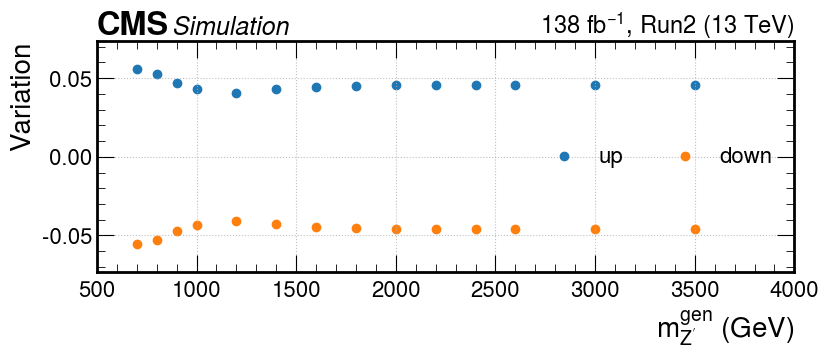

In [19]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]

    arrays['up'][m] = ak.mean((jet_pt<400)*0.055/0.977+((jet_pt>400)&(jet_pt<600))*0.039/1.017+(jet_pt>600)*0.046/1.004)
    arrays['down'][m] = -arrays['up'][m]
    systematics['Xbb_tagger']['SR1'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name=f'tagger_SRH1', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

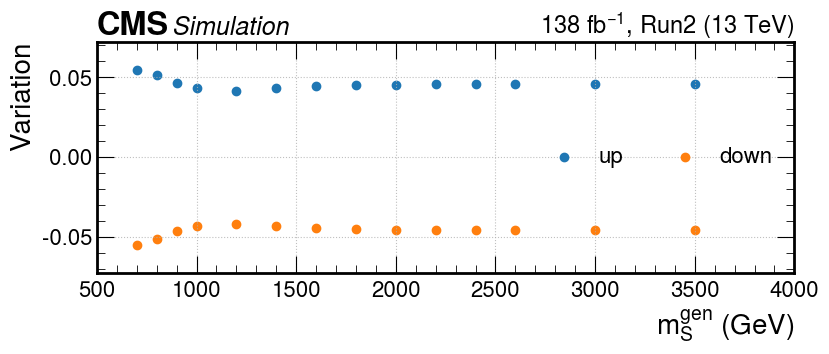

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]

    arrays['up'][m] = ak.mean((jet_pt<400)*0.055/0.977+((jet_pt>400)&(jet_pt<600))*0.039/1.017+(jet_pt>600)*0.046/1.004)
    arrays['down'][m] = -arrays['up'][m]
    systematics['Xbb_tagger']['SR1'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name=f'tagger_SRZ1', x_name=r'$m^{gen}_S$ (GeV)')

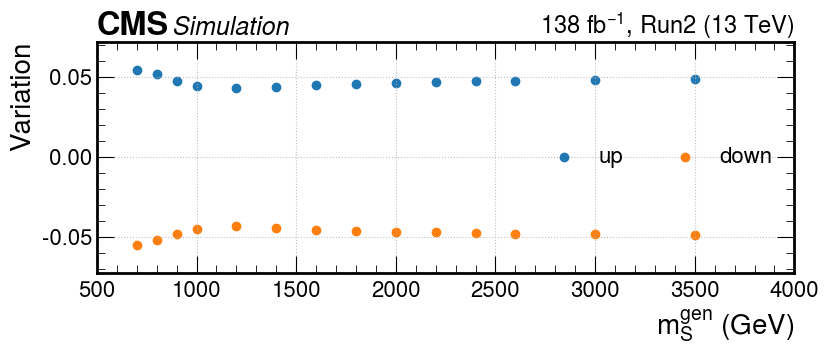

In [25]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.055/0.977+((jet_pt>400)&(jet_pt<600))*0.039/1.017+(jet_pt>600)*0.046/1.004)
    arrays['down'][m] = -arrays['up'][m]

variation_plot(arrays=arrays, plot_name='tagger_SRZ1_W', x_name=r'$m^{gen}_S$ (GeV)')

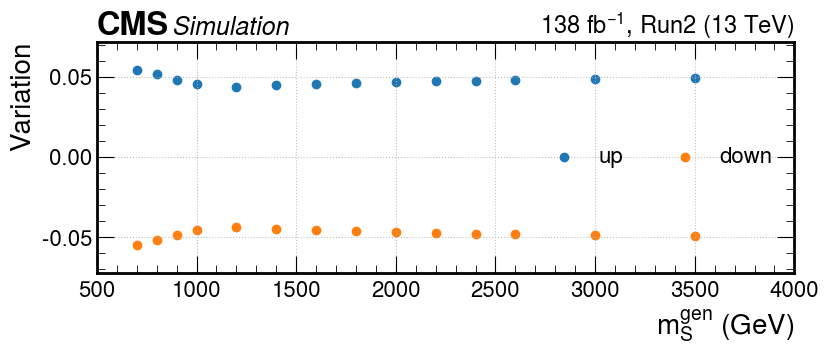

In [26]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.055/0.977+((jet_pt>400)&(jet_pt<600))*0.039/1.017+(jet_pt>600)*0.046/1.004)
    arrays['down'][m] = -arrays['up'][m]

variation_plot(arrays=arrays, plot_name='tagger_SRZ1_VW', x_name=r'$m^{gen}_S$ (GeV)')

### SR2

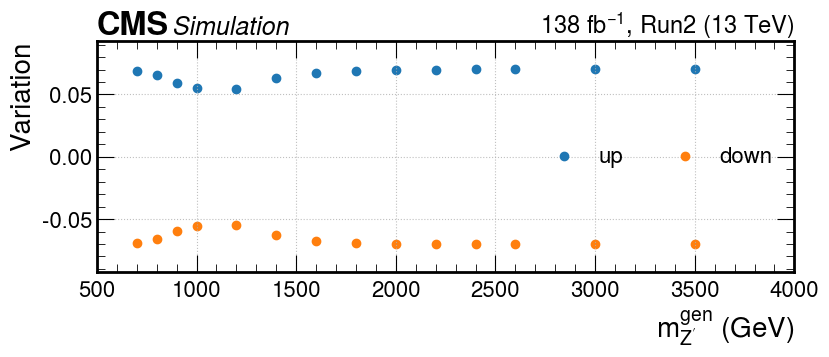

In [27]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.079/1.129+((jet_pt>400)&(jet_pt<600))*0.056/1.111+(jet_pt>600)*0.074/1.054)
    arrays['down'][m] = -arrays['up'][m]
    systematics['Xbb_tagger']['SR2'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='tagger_SRH2', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

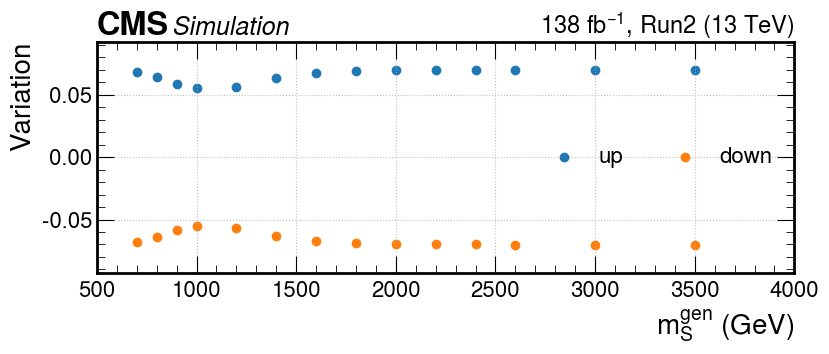

In [28]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.079/1.129+((jet_pt>400)&(jet_pt<600))*0.056/1.111+(jet_pt>600)*0.074/1.054)
    arrays['down'][m] = -arrays['up'][m]

variation_plot(arrays=arrays, plot_name='tagger_SRZ2', x_name=r'$m^{gen}_S$ (GeV)')

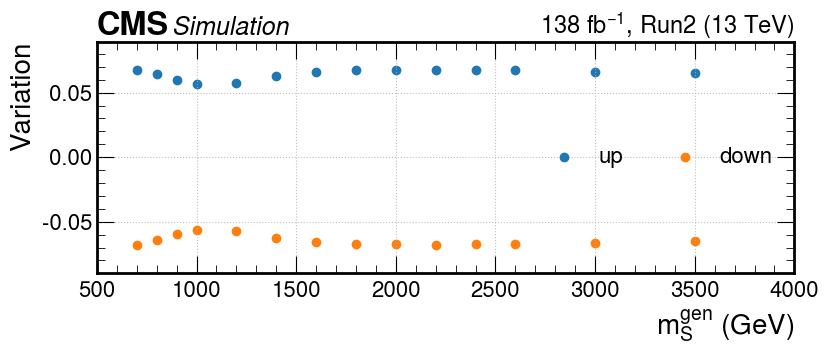

In [29]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.079/1.129+((jet_pt>400)&(jet_pt<600))*0.056/1.111+(jet_pt>600)*0.074/1.054)
    arrays['down'][m] = -arrays['up'][m]

variation_plot(arrays=arrays, plot_name='tagger_SRZ2_W', x_name=r'$m^{gen}_S$ (GeV)')

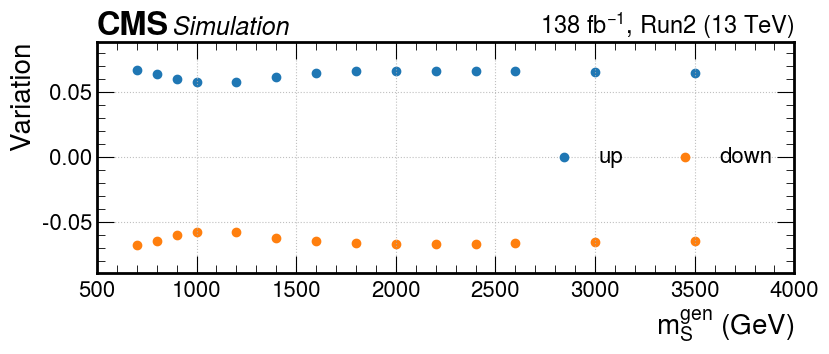

In [30]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.079/1.129+((jet_pt>400)&(jet_pt<600))*0.056/1.111+(jet_pt>600)*0.074/1.054)
    arrays['down'][m] = -arrays['up'][m]

variation_plot(arrays=arrays, plot_name='tagger_SRZ2_VW', x_name=r'$m^{gen}_S$ (GeV)')

## PES

In [39]:
systematics['PES'] = {
    'SR1': {},
    'SR2': {}
}

### SR1

/tmp/ipykernel_2976138/390336684.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))


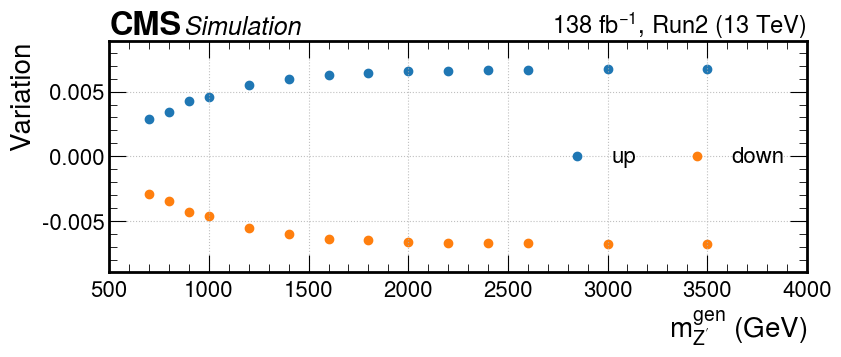

In [112]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])

    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRH1', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/2125502899.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))


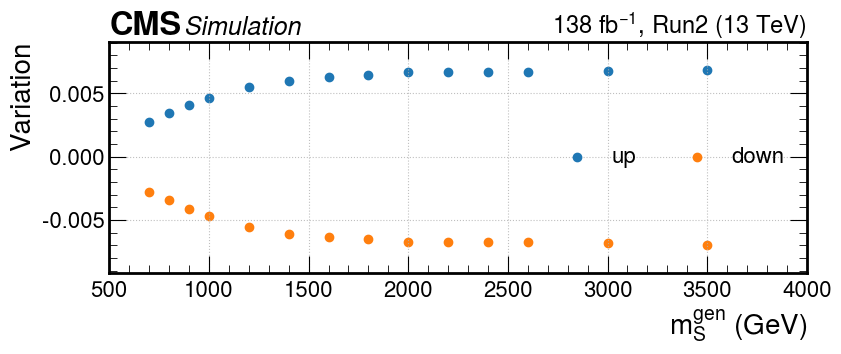

In [113]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ1', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/1481714694.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))


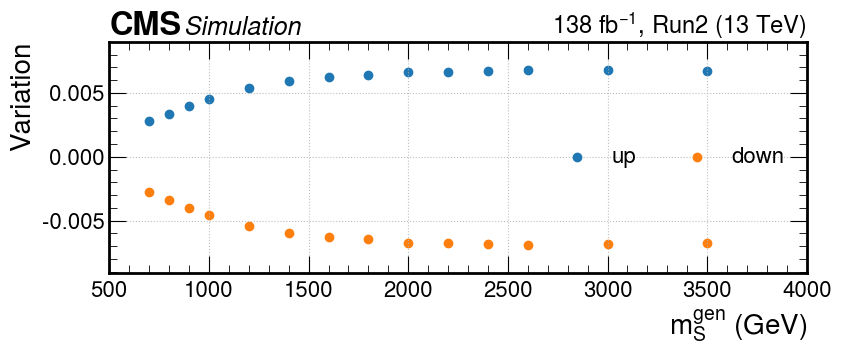

In [114]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ1_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/3320485813.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))


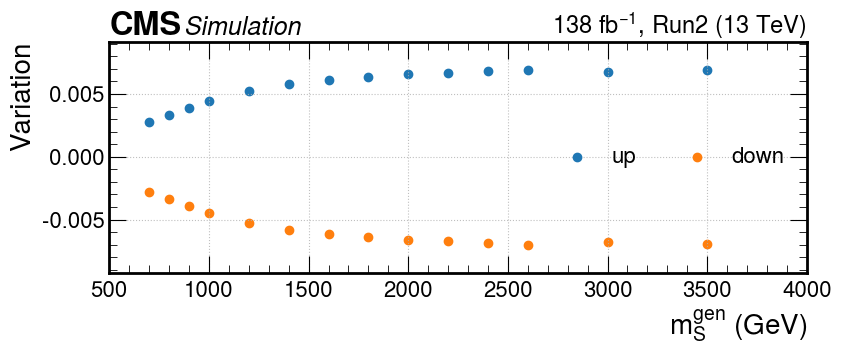

In [115]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ1_VW', x_name=r'$m^{gen}_S$ (GeV)')

### SR2

/tmp/ipykernel_2976138/3485306664.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))


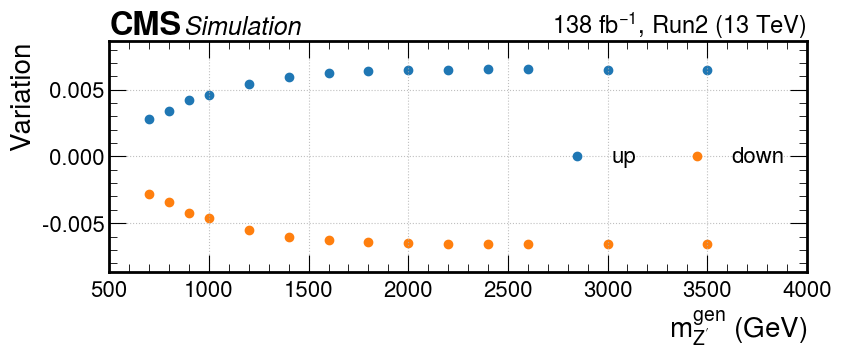

In [116]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRH2', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/4028031254.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))


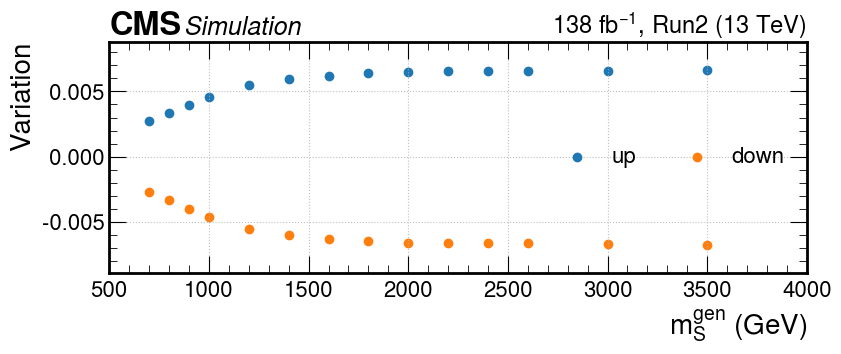

In [117]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ2', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/2711089956.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))


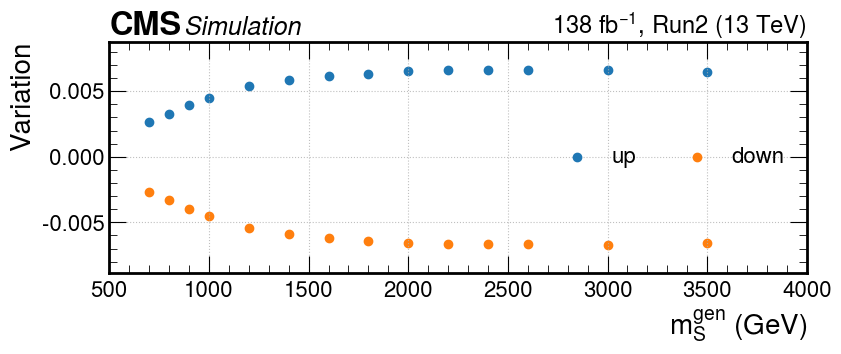

In [118]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ2_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/1364740651.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PES'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))


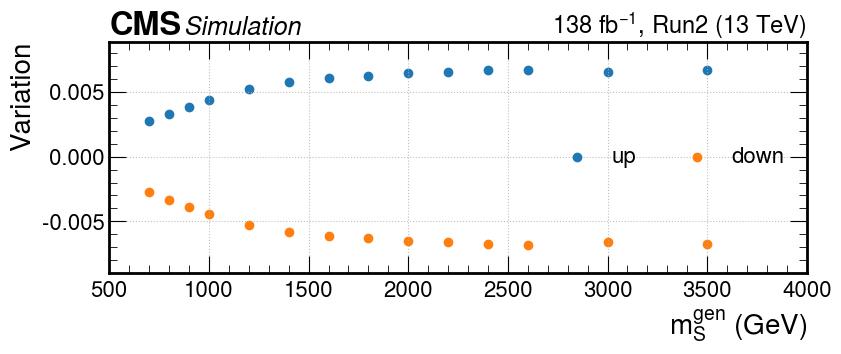

In [119]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['PES'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_SRZ2_VW', x_name=r'$m^{gen}_S$ (GeV)')

## PER

### SR1

/tmp/ipykernel_2976138/4118957715.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))


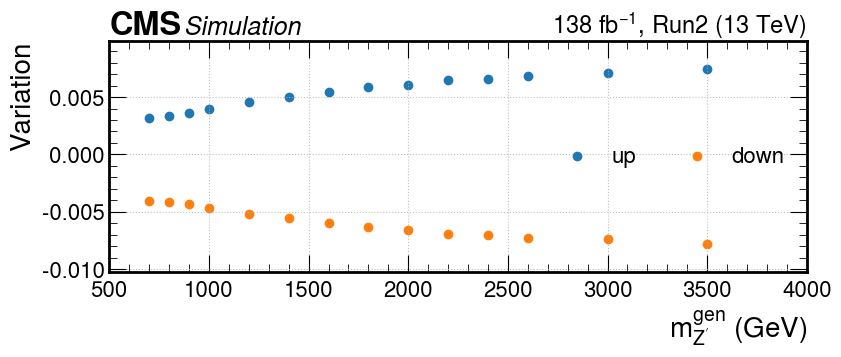

In [121]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }

    #variation['up'][m] = abs(ak.std(arrays['up'])-ak.std(arrays['down']))/(ak.std(arrays['up'])+ak.std(arrays['down']))
    #variation['down'][m] = -variation['up'][m]
    #systematics['PER']['SR1']['H'][m] = float(1+round(variation['up'][m], 3))
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    df['PER'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRH1', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/2765860078.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))


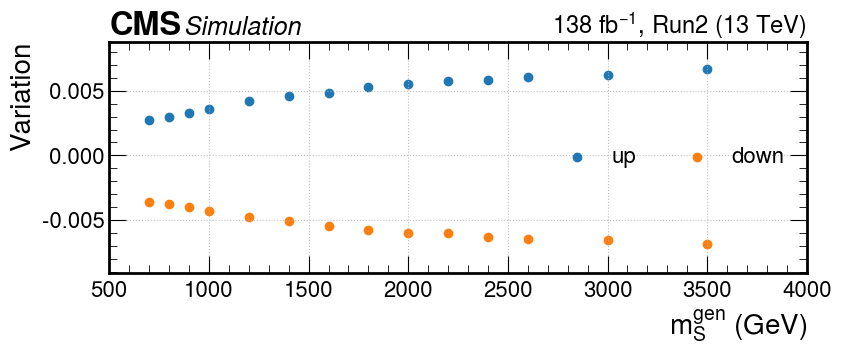

In [122]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    #variation['up'][m] = abs(2*np.std(arrays['up'])/(np.std(arrays['up'])+np.std(arrays['down']))-1)/10
    #variation['down'][m] = -variation['up'][m]
    #systematics['PER']['SR1']['Z'][m] = float(1+round(variation['up'][m], 3))
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    df['PER'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ1', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/1193548216.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))


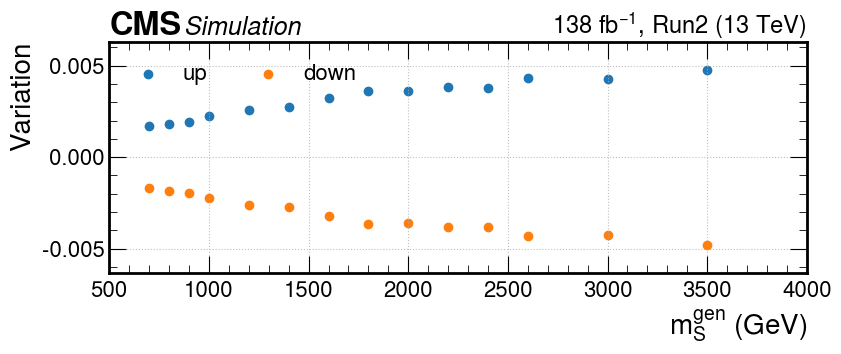

In [123]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.sqrt(abs(ak.std(arrays['up'])/ak.std(arrays['nominal']))-1)*0.01
    variation['down'][m] = -variation['up'][m]
    systematics['PER']['SR1']['Z'][f'{m}_5p6'] = float(1+round(variation['up'][m], 3))
    df['PER'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ1_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/4009909033.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))


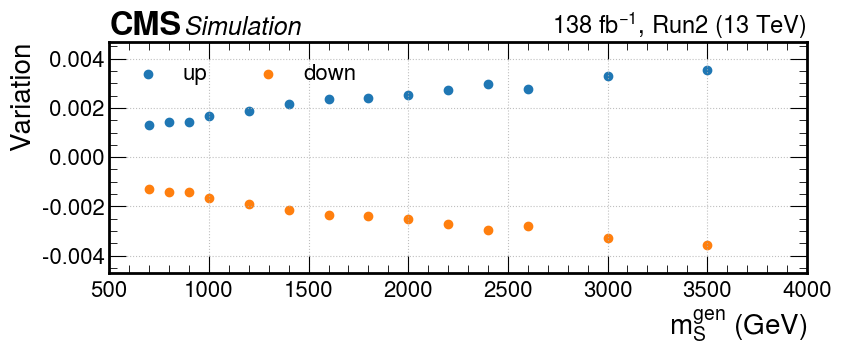

In [124]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.sqrt(abs(ak.std(arrays['up'])/ak.std(arrays['nominal']))-1)*0.01
    variation['down'][m] = -variation['up'][m]
    df['PER'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ1_VW', x_name=r'$m^{gen}_S$ (GeV)')

### SR2

/tmp/ipykernel_2976138/669185079.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))


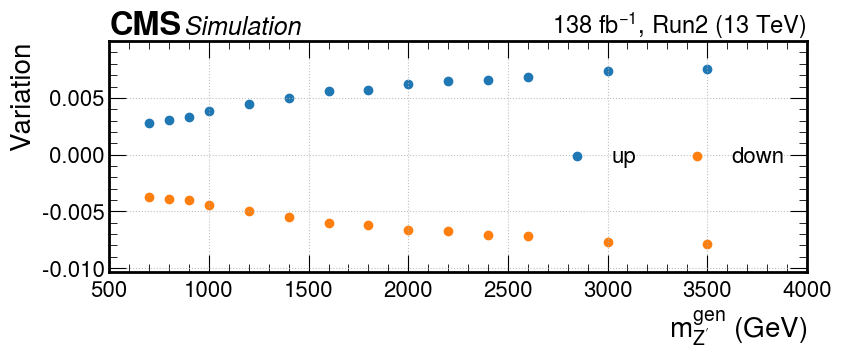

In [125]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    #variation['up'][m] = abs(2*np.std(arrays['up'])/(np.std(arrays['up'])+np.std(arrays['nominal']))-1)/10
    #variation['down'][m] = -variation['up'][m]
    #systematics['PER']['SR2']['H'][m] = float(1+round(variation['up'][m], 3))
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    df['PER'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRH2', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/3586965869.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))


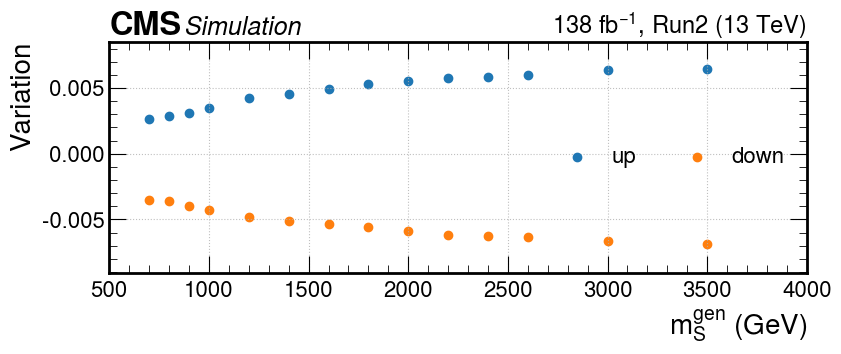

In [126]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    df['PER'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ2', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/3828191715.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))


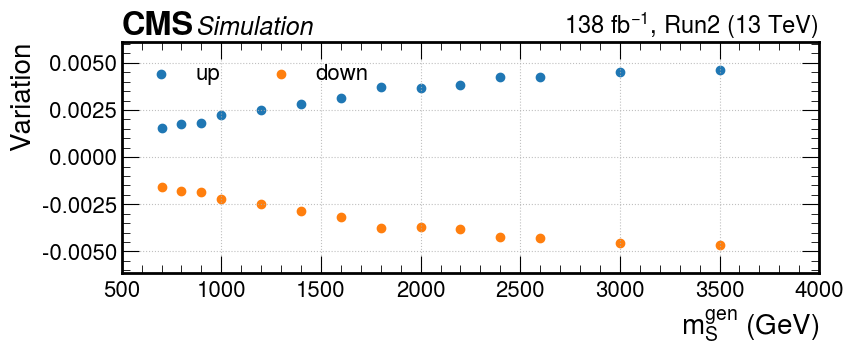

In [127]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }

    variation['up'][m] = np.sqrt(abs(ak.std(arrays['up'])/ak.std(arrays['nominal']))-1)*0.01
    variation['down'][m] = -variation['up'][m]
    df['PER'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ2_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/3893238562.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['PER'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))


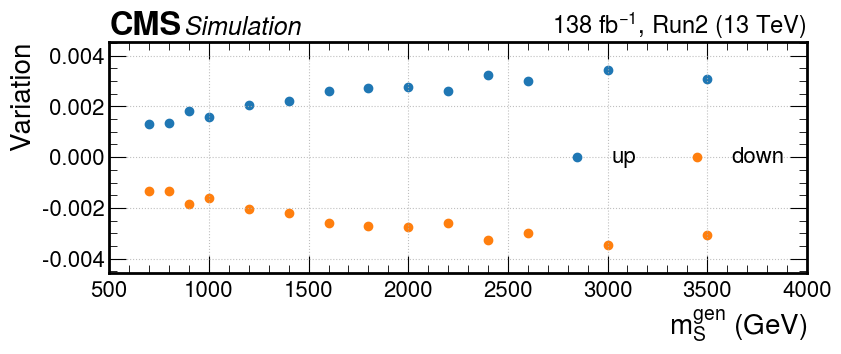

In [128]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }

    variation['up'][m] = np.sqrt(abs(ak.std(arrays['up'])/ak.std(arrays['nominal']))-1)*0.01
    variation['down'][m] = -variation['up'][m]
    df['PER'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_SRZ2_VW', x_name=r'$m^{gen}_S$ (GeV)')

## JES

### SR1

/tmp/ipykernel_2976138/1952317827.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))


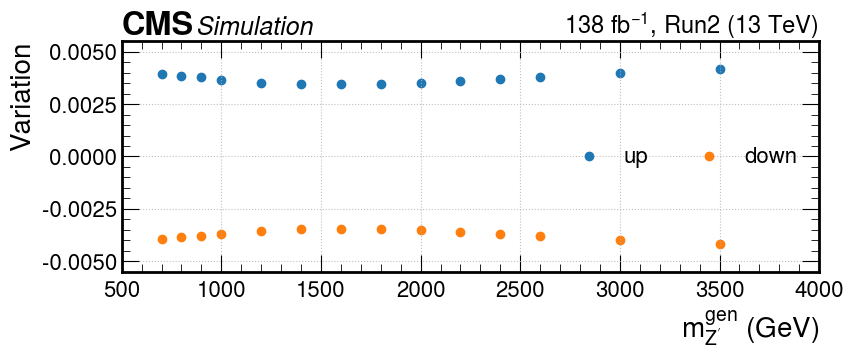

In [130]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass_JEC_nominal'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }

    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['JES'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRH1', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/3359252156.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))


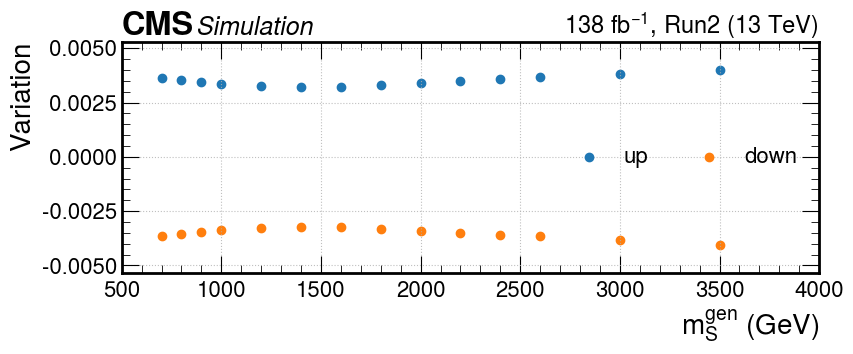

In [131]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass_JEC_nominal'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean(arrays['up'])/np.mean(arrays['nominal'])-1
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    df['JES'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ1', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/3847352511.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))


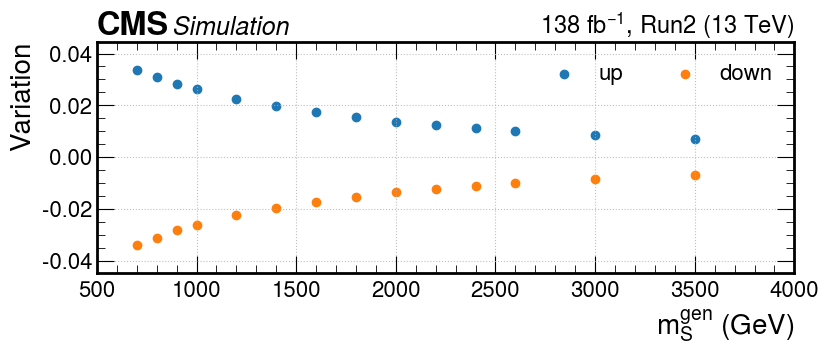

In [132]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }

    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ1_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2984794/2772798593.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))
/tmp/ipykernel_2984794/2772798593.py:31: SettingWithCopyWarning: 
A value is trying to be 

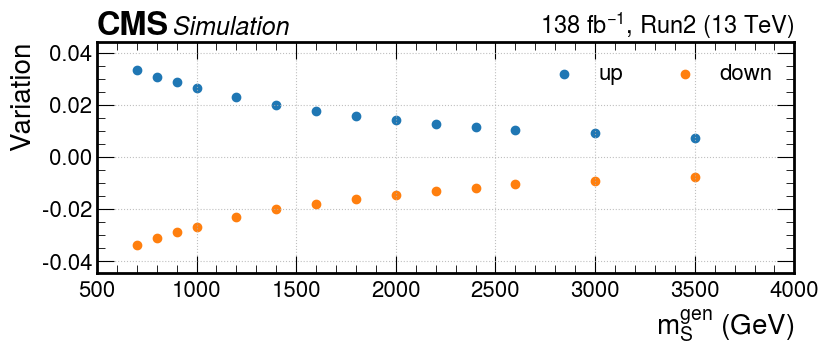

In [39]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ1_VW', x_name=r'$m^{gen}_S$ (GeV)')

### SR2

/tmp/ipykernel_2984794/1668410393.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))
/tmp/ipykernel_2984794/1668410393.py:31: SettingWithCopyWarning: 
A value is trying to be s

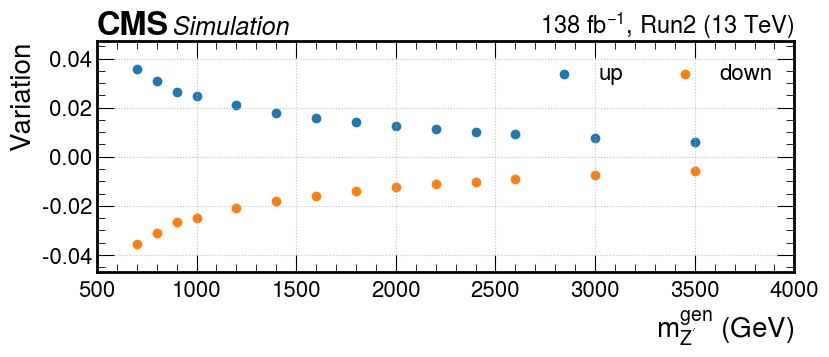

In [33]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRH2', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/3656370277.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))


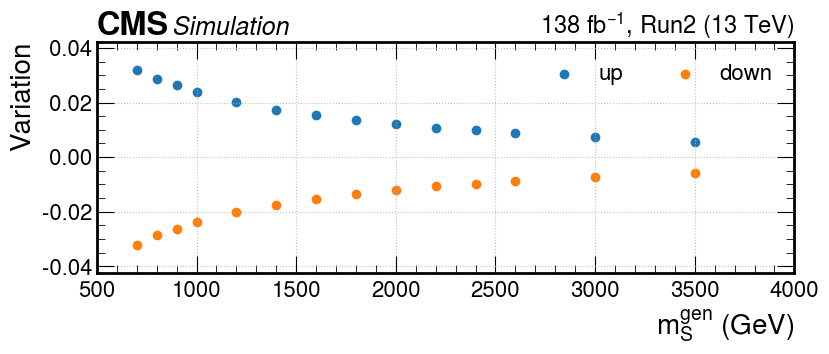

In [135]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1),abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ2', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/4155778307.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))


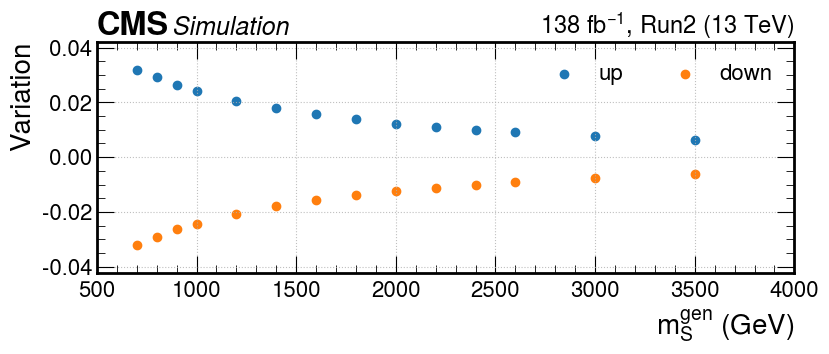

In [136]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ2_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2984794/3672445982.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JES'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))
/tmp/ipykernel_2984794/3672445982.py:30: SettingWithCopyWarning: 
A value is trying to be 

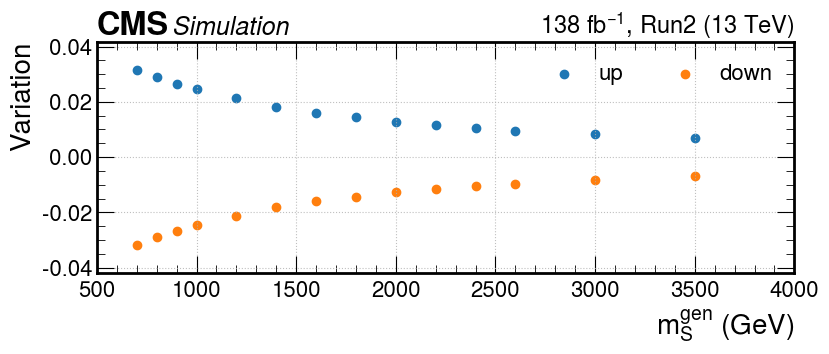

In [38]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    df['JES'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_SRZ2_VW', x_name=r'$m^{gen}_S$ (GeV)')

### rate effects

In [178]:
def JES_rate_effect(year, channel, SR, pt_cut):
    tagger_cut = {
        'SR1': {'down': 0.8, 'up': 0.98},
        'SR2': {'down': 0.98, 'up': 2},
    }
    jet = channel.split('$')[2][0]
    jet_mass_cut = {
        'H': {'down': 110, 'up': 150},
        'Z': {'down': 80, 'up': 110}
    }
    jet_pt = {'up': {}, 'down': {}, 'nominal': {}}

    cut = f"""(
        (events[year][channel]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[year][channel].photon_eta) < 1.4442) & 
        (np.abs(events[year][channel].AK8jet_eta) < 2.4) & 
        (events[year][channel].photon_pt/events[y][channel]['photon+jet_mass'] > 0.35) & 
        (events[year][channel]['AK8jet_Xbb_tagger']>{tagger_cut[SR]['down']}) & 
        (events[year][channel]['AK8jet_Xbb_tagger']<{tagger_cut[SR]['up']}) & 
        (events[year][channel]['AK8jet_particleNet_mass'] > {jet_mass_cut[jet]['down']}) & 
        (events[year][channel]['AK8jet_particleNet_mass'] < {jet_mass_cut[jet]['up']})
    )"""
    jet_pt={
        'up': events[year][channel]['AK8jet_pt_JES_up'][eval(cut)],
        'nominal': events[year][channel]['AK8jet_pt_JEC_nominal'][eval(cut)],
        'down': events[year][channel]['AK8jet_pt_JES_down'][eval(cut)]
    }

    pass_efficiency = {k: ak.sum(jet_pt[k]>pt_cut)/len(jet_pt[k]) for k in jet_pt}
    return pass_efficiency['down']/pass_efficiency['nominal']

In [ ]:
JES_rate_effect(year='Run2', channel=r'700$\to$H(bb)$\gamma$', SR='SR1', pt_cut=250)

0.9958864968717671

In [ ]:
JES_rate_effect(year='Run2', channel=r'700$\to$H(bb)$\gamma$', SR='SR2', pt_cut=250)

0.9960507520376438

In [185]:
JES_rate_effect(year='Run2', channel=r'700$\to$Z(bb)$\gamma$', SR='SR1', pt_cut=250)

0.9958707796939519

In [186]:
JES_rate_effect(year='Run2', channel=r'700$\to$Z(bb)$\gamma$', SR='SR2', pt_cut=250)

0.9960612691466084

## JER

### SR1

/tmp/ipykernel_2976138/4194728561.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))


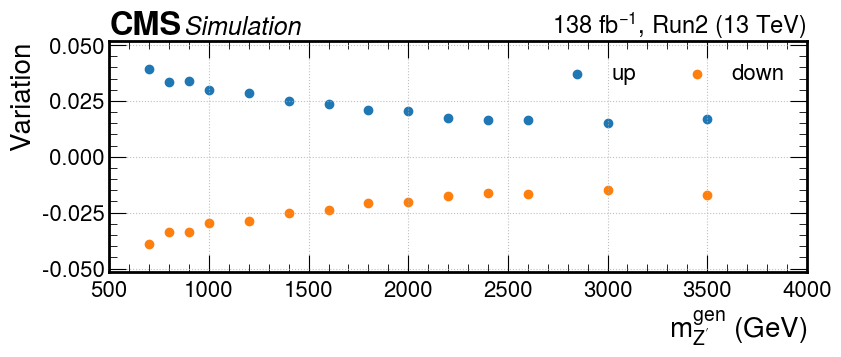

In [139]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays = {
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }

    variation['up'][m] = min(np.std(arrays['up'])/np.std(arrays['nominal'])-1, np.std(arrays['down'])/np.std(arrays['nominal'])-1)/2
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRH1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRH1', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/2570169128.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))


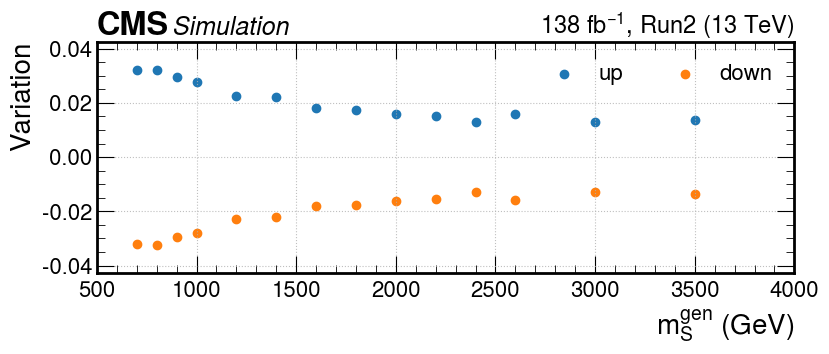

In [140]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.std(arrays['up'])/np.std(arrays['nominal'])-1, np.std(arrays['down'])/np.std(arrays['nominal'])-1)/2
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ1_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRZ1', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2976138/1421265433.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))


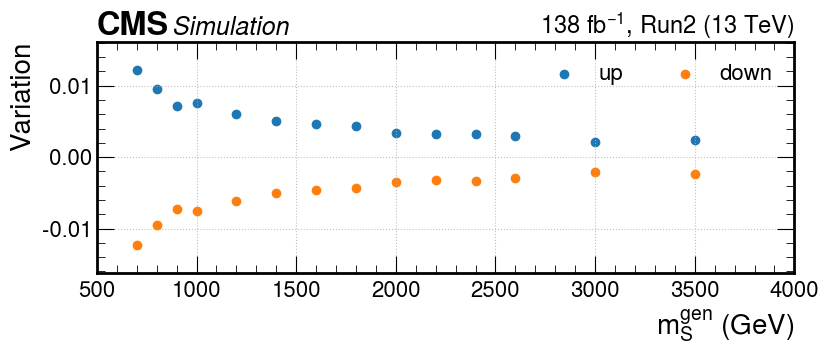

In [141]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }

    variation['up'][m] = np.std(arrays['up'])/np.std(arrays['down'])-1
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ1_W'] = float(1+round(variation['up'][m], 3))
    

variation_plot(arrays=variation, plot_name='JER_SRZ1_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2984794/565851288.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))
/tmp/ipykernel_2984794/565851288.py:32: SettingWithCopyWarning: 
A value is trying to be se

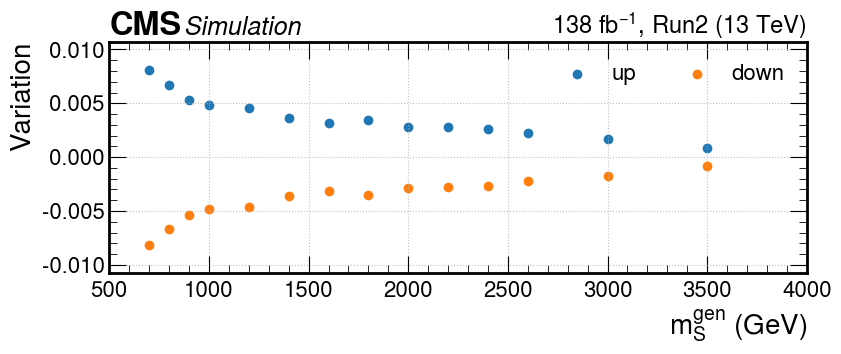

In [34]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = abs(np.std(arrays['up'])/np.std(arrays['down'])-1+0.001)
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ1_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRZ1_VW', x_name=r'$m^{gen}_S$ (GeV)')

### SR2

/tmp/ipykernel_2976138/2876948468.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))


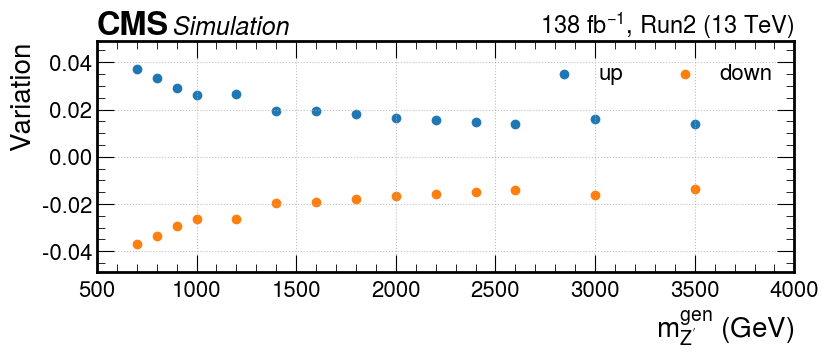

In [143]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.std(arrays['up'])/np.std(arrays['nominal'])-1, np.std(arrays['down'])/np.std(arrays['nominal'])-1)/2
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRH2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRH2', x_name=r'$m^{gen}_{Z^\prime}$ (GeV)')

/tmp/ipykernel_2976138/1022417801.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))


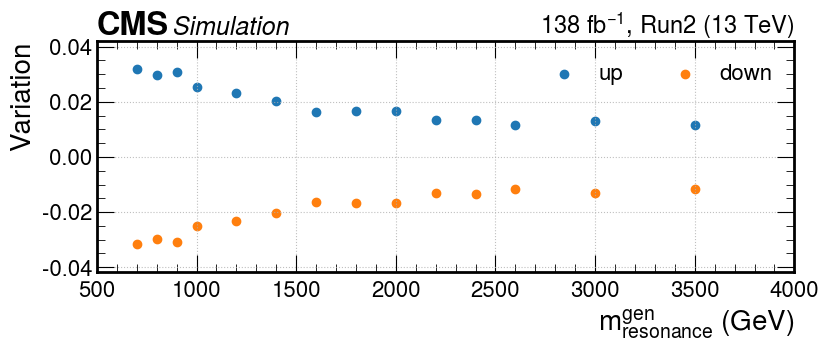

In [144]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.std(arrays['up'])/np.std(arrays['nominal'])-1, np.std(arrays['down'])/np.std(arrays['nominal'])-1)/2
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ2_N'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRZ2', x_name=r'$m^{gen}_{resonance}$ (GeV)')

/tmp/ipykernel_2976138/4216800440.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))


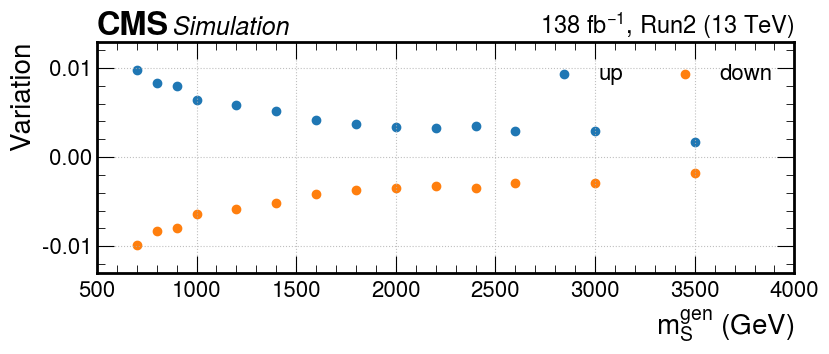

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }

    variation['up'][m] = np.std(arrays['up'])/np.std(arrays['down'])-1
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ2_W'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRZ2_W', x_name=r'$m^{gen}_S$ (GeV)')

/tmp/ipykernel_2984794/1375126791.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['JER'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))
/tmp/ipykernel_2984794/1375126791.py:31: SettingWithCopyWarning: 
A value is trying to be 

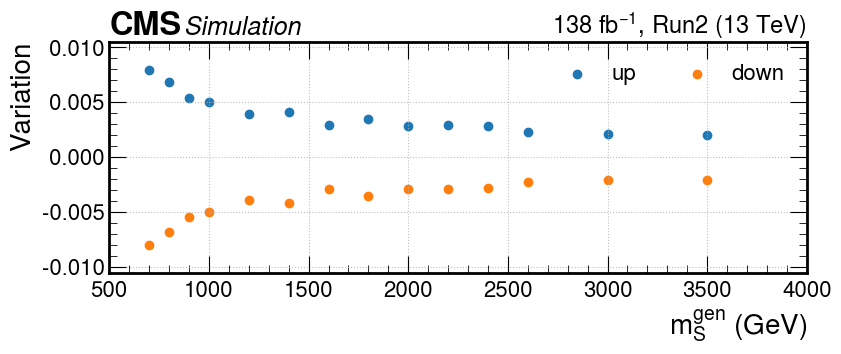

In [35]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    width = 'W' if '_5p6' in k else 'VW' if '_10p0' in k else 'N'
    frac = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m-frac*m}) & 
        (events[y][k]['photon+jet_mass'] < {m+frac*m})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.std(arrays['up'])/np.std(arrays['down'])-1+0.001
    variation['down'][m] = -variation['up'][m]
    df['JER'][m, 'SRZ2_VW'] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_SRZ2_VW', x_name=r'$m^{gen}_S$ (GeV)')

## QCD Scale

In [14]:
_weight_sum = {y: {} for y in ['2016pre', '2016post', '2017', '2018']}
for y in _weight_sum:
    channel_dir = os.path.join(base, f'mc/{y}/ZpToHG')
    for job in os.listdir(channel_dir):
        mass = int(job.split('M')[-1])
        file = os.path.join(channel_dir, f'{job}/mc_{y}_ZpToHG.yaml')
        if not os.path.exists(file):
            continue
        with open(os.path.join(channel_dir, f'{job}/mc_{y}_ZpToHG.yaml'), 'r', encoding='utf-8') as f:
            _weight_sum[y][mass] = yaml.safe_load(f)

weight_sum = {
    mass: {
        k.split('_')[-1]: ak.sum([_weight_sum[y][mass][k] for y in ['2016pre', '2016post', '2017', '2018'] if 'Scale' in k or k=='n_events'])
        for k in _weight_sum['2018'][mass] if 'Scale' in k or k=='n_events'
    } for mass in _weight_sum['2018']
}

In [16]:
hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def scale_uncertainty_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    ratio = {}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        
        if weight is not None:
            hist.fill(v, weight=weight[k])
        else:
            hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio[k] = h / individual['h']['nominal']
        #ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio[k], bins=hist.axes[0].edges, yerr=0, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(ax1.get_ylim()[0]*1.2-0.2, ax1.get_ylim()[1]*1.2-0.2)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

    if 'up' in ratio and 'down' in ratio:
        return np.nanmax(ratio['up']), np.nanmin(ratio['down'])

/tmp/ipykernel_1845431/2655122882.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


/tmp/ipykernel_1845431/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1845431/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1845431/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1845431/1570538259.py:50: RuntimeWarning: invalid value encountered in divide
  ratio[k] = h / individual['h']['nominal']
/tmp/ipykernel_1845431/2098487461.py:32: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1845431/2098487461.py:49: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1845431/2098487461.py:50: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1845431/1570538259

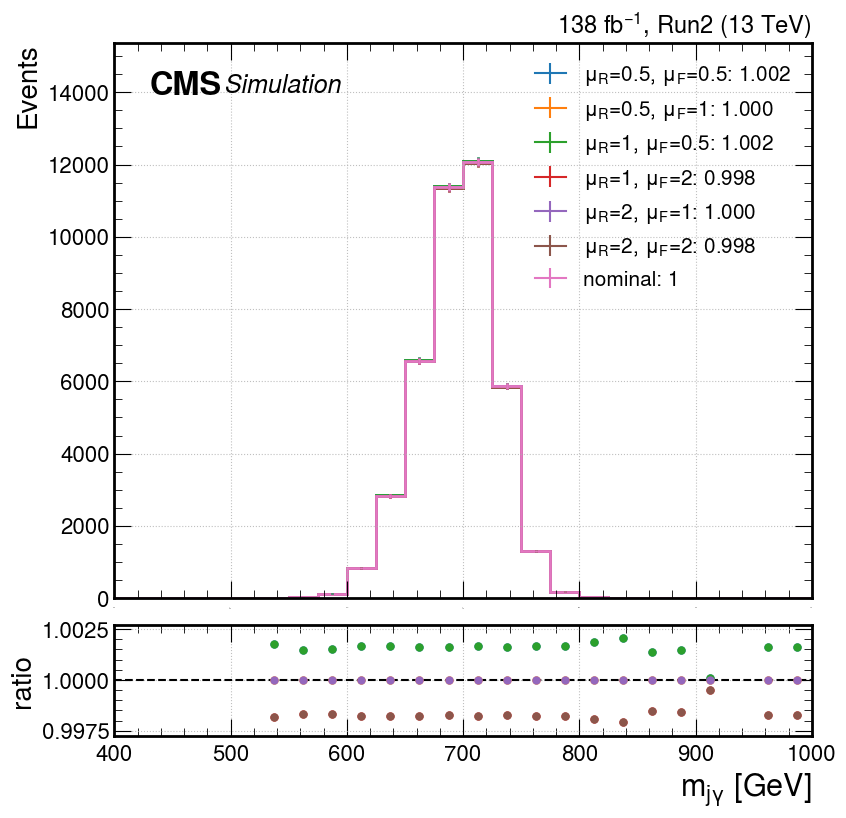

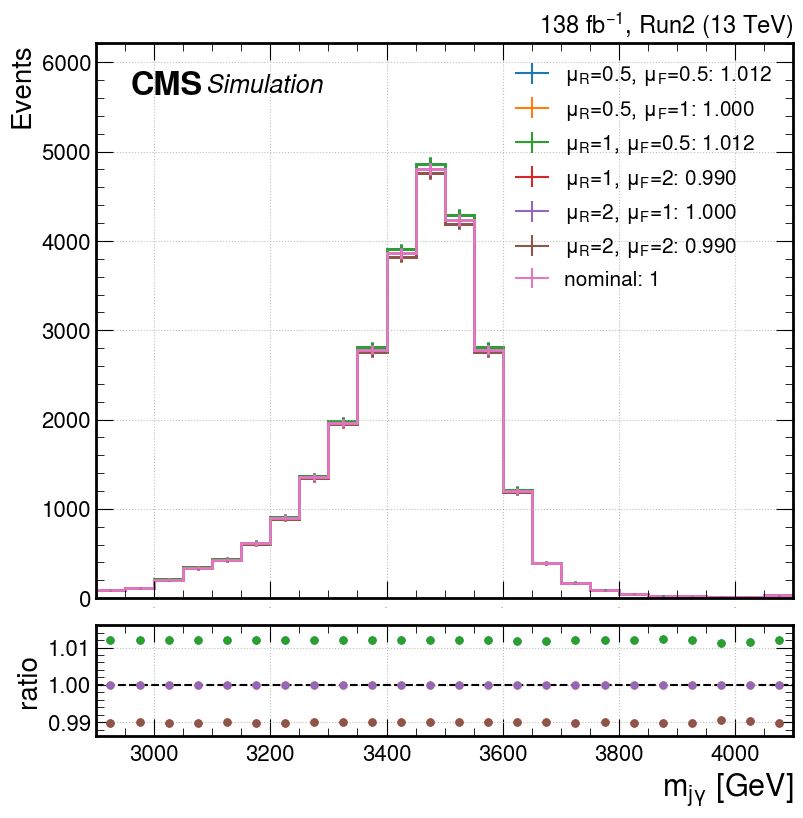

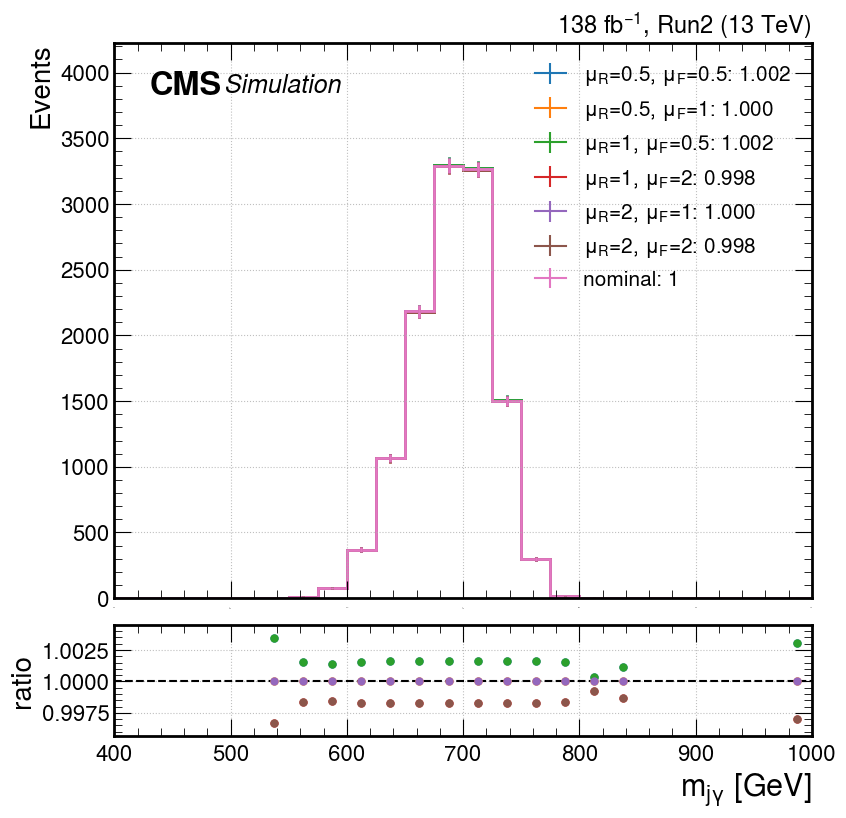

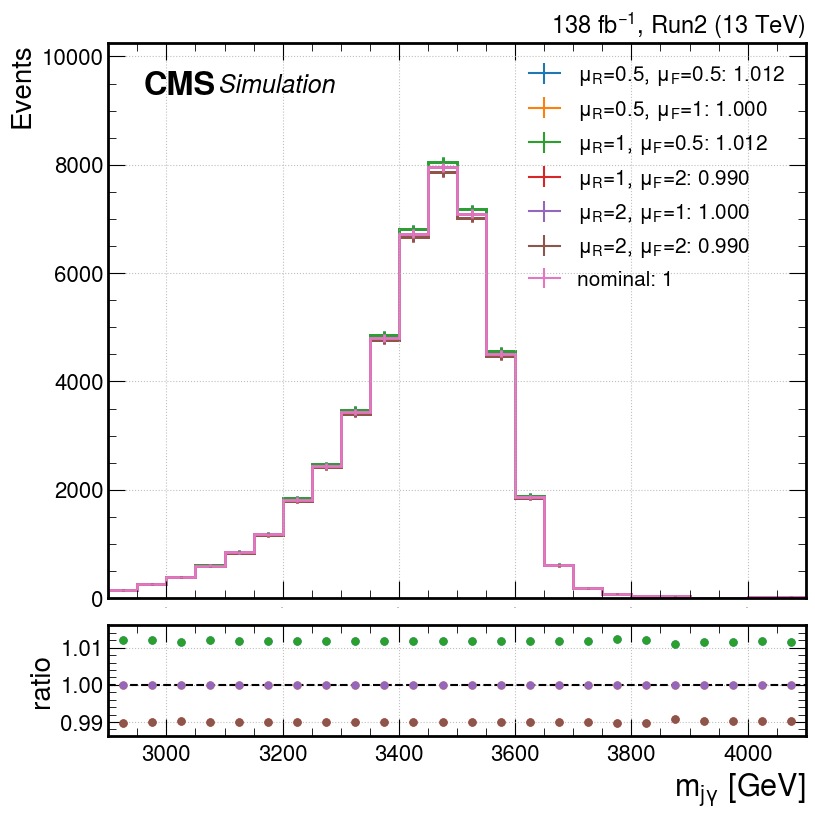

In [ ]:
y='Run2'
for m in (700, 3500):
    k = str(m)+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.8) & 
        (events[y][k].AK8jet_Xbb_tagger<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 0][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': 0.1*events[y][k]['LHEScaleWeight'][:, 1][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        #r'$\mu_R$=0.5, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 2][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 3][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        'nominal': ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 4][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        #r'$\mu_R$=2, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 5][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': 0.1*events[y][k]['LHEScaleWeight'][:, 6][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 7][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$ (GeV)', plot_name=f'QCD_scales_{m}_SRH1', x_min=int(m)-100*round(np.sqrt(int(m)/100),0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=25 if int(m)<1500 else 50, weight=_weight, year=y)
    
y='Run2'
for m in (700, 3500):
    k = str(m)+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    
    
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 0][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': 0.1*events[y][k]['LHEScaleWeight'][:, 1][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        #r'$\mu_R$=0.5, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 2][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 3][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        'nominal': ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 4][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        #r'$\mu_R$=2, $\mu_F$=0.5': 0.1*events[y][k]['LHEScaleWeight'][:, 5][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': 0.1*events[y][k]['LHEScaleWeight'][:, 6][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': 0.1*events[y][k]['LHEScaleWeight'][:, 7][eval(cut)]+0.9*ak.ones_like(events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$ (GeV)', plot_name=f'QCD_scales_{m}_SRH2', x_min=int(m)-100*round(np.sqrt(int(m)/100),0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=25 if int(m)<1500 else 50, weight=_weight, year=y)

### SR1

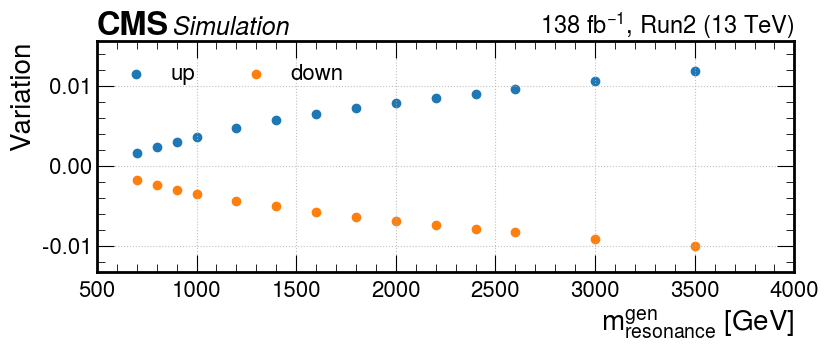

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    ratio['up'][m] = np.max([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['up'][m] = 0.1*ratio['up'][m]+0.9
    ratio['down'][m] = np.min([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['down'][m] = 0.1*ratio['down'][m]+0.9
    systematics['QCD_scale']['SR1'][m] = f'{round(float(ratio['down'][m]),3)}/{round(float(ratio['up'][m]),3)}'

arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='QCD_scale_SRH1', x_name=r'$m^{gen}_{resonance}$ (GeV)')

### SR2

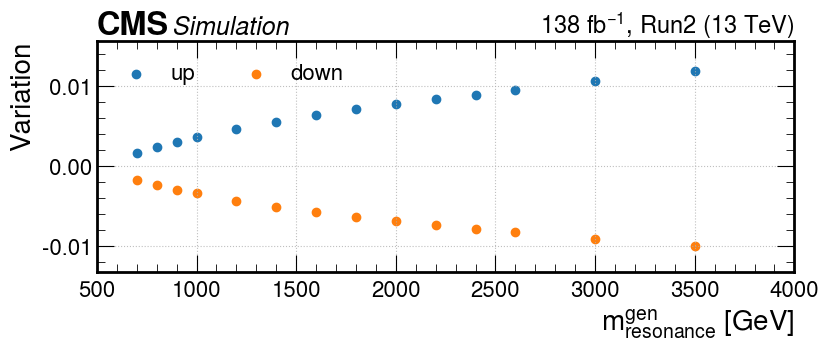

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    ratio['up'][m] = np.max([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['up'][m] = 0.1*ratio['up'][m]+0.9
    ratio['down'][m] = np.min([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['down'][m] = 0.1*ratio['down'][m]+0.9
    systematics['QCD_scale']['SR2'][m] = f'{round(float(ratio['down'][m]),3)}/{round(float(ratio['up'][m]),3)}'
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='QCD_scale_SRH2', x_name=r'$m^{gen}_{resonance}$ (GeV)')

## PDF

In [45]:
systematics['PDF'] = {
    'SR1': {},
    'SR2': {}
}

In [46]:
_weight_sum = {y: {} for y in ['2016pre', '2016post', '2017', '2018']}
for y in _weight_sum:
    channel_dir = os.path.join(base, f'mc/{y}/ZpToHG')
    for job in os.listdir(channel_dir):
        mass = int(job.split('M')[-1])
        file = os.path.join(channel_dir, f'{job}/mc_{y}_ZpToHG.yaml')
        if not os.path.exists(file):
            continue
        with open(os.path.join(channel_dir, f'{job}/mc_{y}_ZpToHG.yaml'), 'r', encoding='utf-8') as f:
            _weight_sum[y][mass] = yaml.safe_load(f)

weight_sum = {
    mass: {
        int(k.split('_')[-1]): ak.sum([_weight_sum[y][mass][k] for y in ['2016pre', '2016post', '2017', '2018'] if 'Pdf' in k])
        for k in _weight_sum['2018'][mass] if 'Pdf' in k
    } for mass in _weight_sum['2018']
}

In [35]:
def pdf_uncertainty_plot(array, weight, weight_sum, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    ratio = {}
    hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
    hist.fill(array, weight=weight[:, 0])
    h, var = flow(hist=hist, overflow=False, underflow=False)
    individual['h']['nominal'] = h
    individual['var']['nominal'] = np.sqrt(h)
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    delta_h = np.sqrt(np.sum([(histogram[i]*weight_sum[0]/weight_sum[i]-histogram[0])**2 for i in histogram if i!=0], axis=0))/1.5
    individual['h']['up'] = individual['h']['nominal']  + delta_h
    individual['var']['up'] = np.sqrt(individual['h']['up'])
    individual['h']['down'] = individual['h']['nominal'] - delta_h
    individual['var']['down'] = np.sqrt(individual['h']['down'])
    
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio[k] = h / individual['h']['nominal']
        #ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio[k], bins=hist.axes[0].edges, yerr=0, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(np.sum(individual['h']['down'])/np.sum(h_nominal)*2-1, np.sum(individual['h']['up'])/np.sum(h_nominal)*2-1)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

    #return np.nanmax(ratio['up']), np.nanmin(ratio['down'])

In [ ]:
y='Run2'
for m in (700, 3500):
    k = str(m)+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.8) & 
        (events[y][k].AK8jet_Xbb_tagger<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = (events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    pdf_uncertainty_plot(array, weight=_weight, weight_sum=weight_sum[m], x_name=r'$m_{j\gamma}$ (GeV)', plot_name=f'PDF_{m}_SRH1', x_min=int(m)-100*round(np.sqrt(int(m)/100),0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=25 if int(m)<1500 else 50, year=y)
    
y='Run2'
for m in (700, 3500):
    k = str(m)+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    
    _weight = (events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    pdf_uncertainty_plot(array, weight=_weight, weight_sum=weight_sum[m], x_name=r'$m_{j\gamma}$ (GeV)', plot_name=f'PDF_{m}_SRH2', x_min=int(m)-100*round(np.sqrt(int(m)/100), 0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=25 if int(m)<1500 else 50, year=y)

### SR1

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])

    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    
    bin_width = 50
    x_max = m+3*mass_widow
    x_min = m-3*mass_widow
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(_weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=_weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    h_var = np.sqrt(np.sum([(histogram[i]*weight_sum[m][0]/weight_sum[m][i]-histogram[0])**2 for i in histogram if i!=0], axis=0))
    arrays['up'][m] = np.sum(h_var)/np.sum(histogram[0])
    arrays['up'][m] = arrays['up'][m]/1.5
    arrays['down'][m] = -arrays['up'][m]
    systematics['PDF']['SR1'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='PDF_SRH1', x_name=r'$m^{gen}_{resonance}$ (GeV)')

### SR2

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])

    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m}-3*{mass_widow}) &
        (events[y][k]['photon+jet_mass'] < {m}+3*{mass_widow})
    )"""
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    
    bin_width = 50
    x_max = m+3*mass_widow
    x_min = m-3*mass_widow
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(_weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=_weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    h_var = np.sqrt(np.sum([(histogram[i]*weight_sum[m][0]/weight_sum[m][i]-histogram[0])**2 for i in histogram if i!=0], axis=0))
    arrays['up'][m] = np.sum(h_var)/np.sum(histogram[0])
    arrays['up'][m] = arrays['up'][m]/1.5
    arrays['down'][m] = -arrays['up'][m]
    systematics['PDF']['SR2'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='PDF_SRH2', x_name=r'$m^{gen}_{resonance}$ (GeV)')

## Trigger Efficiency

In [21]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$Z(bb)$\gamma$': 'blue',
    r'2000$\to$H(bb)$\gamma$': 'blue',
    #r'2000$\to$Z(bb)$\gamma$': 'cyan',
    r'3000$\to$H(bb)$\gamma$': 'yellow',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

hep.style.use("CMS")

def trigger_efficiency_plot(arrays, triggered, weight, plot_name: str, x_name: str, year='Run2', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, x_axis=None, bin_width=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min) // bin_width

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')

    ## analyze
    histogram = {'raw':{}, 'triggered': {}}
    h_err = {'raw':{}, 'triggered': {}}
    efficiency = {}
    eff_err = {}
    ratio_err = {}

    for (k, v) in arrays.items():
        for mode in ('raw', 'triggered'):
            if x_axis is None:
                hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
            else:
                hist = bh.Histogram(x_axis, storage=bh.storage.Weight())

            v = (v if mode=='raw' else v[triggered[k]==1])
            w = (weight[k] if mode=='raw' else weight[k][triggered[k]==1])
            hist.fill(v, weight=w)
            h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
            histogram[mode][k] = h
            h_err[mode][k] = error_bar(histogram[mode][k], var, mode=('data' if k=='data' else 'mc'))

    eff_err_custom = {}
    for k in histogram['raw']:
        efficiency[k] = histogram['triggered'][k]/histogram['raw'][k]
        eff_err[k] = h_err['raw'][k] / histogram['raw'][k]
        eff_err_custom[k] = np.copy(eff_err[k])
        eff_err_custom[k][1] = np.min([1-efficiency[k], eff_err_custom[k][1]], axis=0)

    ## plot
    for (k, eff) in efficiency.items():
        if k != 'data':
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=5, stack=False, linewidth=2, ax=ax, capsize=4)
            ratio = efficiency['data']/eff
            ratio_err[k] = ratio * np.sqrt((eff_err['data']/efficiency['data'])**2)
            hep.histplot(ratio, bins=hist.axes[0].edges, xerr=True, yerr=ratio_err[k], label=k, histtype='errorbar', markersize=5, density=density, stack=False, linewidth=2, ax=ax1, capsize=4)
        else:
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=10, stack=False, linewidth=2, ax=ax, color='black', capsize=4)
    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0.6, 1.2)
    ax.set_xticklabels([])
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel(r'$\varepsilon_{trigger}$', fontsize=22, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax1.set_ylim(0.8, 1.2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel(r'SF=$\frac{\varepsilon(data)}{\varepsilon(MC)}$', fontsize=22, ha='right', y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    
    return ratio_err

In [ ]:
y = 'Run2'
arrays = {}
triggered = {}
for k in list(SIG_COLOR.keys())+['data']:
    arrays[k] = events[y][k]['photon_pt']
    if k == 'data':
        triggered[k] = events[y][k]['triggered'] | (np.abs(events[y][k]['photon_eta'])<1.4442)
    else:
        triggered[k] = events[y][k]['triggered'] | (np.abs(events[y][k]['photon_eta'])<1.4442)

SF_err = trigger_efficiency_plot(arrays, triggered, x_name=r'$p_T(\gamma)$', plot_name=f'trigger_efficiency', weight=weight[y], x_axis=bh.axis.Variable([200, 250, 300, 400, 600, 1200, 3000]), x_min=200, x_max=3000, year=y, underflow=False, overflow=True)
SF_err


In [ ]:
y='Run2'
k=r'1000$\to$H(bb)$\gamma$'
arrays = events[y][k].photon_pt
weight_nominal = ak.ones_like(events[y][k].photon_pt)
weight_down = (weight_nominal - 
    ((arrays>200) & (arrays<250))*SF_err[k][0][0] -
    ((arrays>250) & (arrays<300))*SF_err[k][0][1] - 
    ((arrays>300) & (arrays<400))*SF_err[k][0][2] - 
    ((arrays>400) & (arrays<600))*SF_err[k][0][3] - 
    ((arrays>600) & (arrays<1200))*SF_err[k][0][4] - 
    ((arrays>1200) & (arrays<3000))*SF_err[k][0][5]
)
weight_up = (weight_nominal + 
    ((arrays>200) & (arrays<250))*SF_err[k][1][0] + 
    ((arrays>250) & (arrays<300))*SF_err[k][1][1] + 
    ((arrays>300) & (arrays<400))*SF_err[k][1][2] + 
    ((arrays>400) & (arrays<600))*SF_err[k][1][3] + 
    ((arrays>600) & (arrays<1200))*SF_err[k][1][4] + 
    ((arrays>1200) & (arrays<3000))*SF_err[k][1][5]
)



ak.mean(weight_down), ak.mean(weight_up)

In [ ]:
k=r'2000$\to$H(bb)$\gamma$'
arrays = events[y][k].photon_pt
weight_nominal = ak.ones_like(events[y][k].photon_pt)
weight_down = (weight_nominal - 
    ((arrays>200) & (arrays<250))*SF_err[k][0][0] -
    ((arrays>250) & (arrays<300))*SF_err[k][0][1] - 
    ((arrays>300) & (arrays<400))*SF_err[k][0][2] - 
    ((arrays>400) & (arrays<600))*SF_err[k][0][3] - 
    ((arrays>600) & (arrays<1200))*SF_err[k][0][4] - 
    ((arrays>1200) & (arrays<3000))*SF_err[k][0][5]
)
weight_up = (weight_nominal + 
    ((arrays>200) & (arrays<250))*SF_err[k][1][0] + 
    ((arrays>250) & (arrays<300))*SF_err[k][1][1] + 
    ((arrays>300) & (arrays<400))*SF_err[k][1][2] + 
    ((arrays>400) & (arrays<600))*SF_err[k][1][3] + 
    ((arrays>600) & (arrays<1200))*SF_err[k][1][4] + 
    ((arrays>1200) & (arrays<3000))*SF_err[k][1][5]
)



ak.mean(weight_down), ak.mean(weight_up)

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (events[y][k]['photon-jet_deltaR']<1.1) & 
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.96) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR1', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

y='Run2'
for m in ('1000', '2000', '3000'):
    k=m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (events[y][k]['photon-jet_deltaR']<1.1) & 
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.96) & 
        (events[y][k]['AK8jet_Xbb_tagger']<2) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR2', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

# Signal interpolation

## systematics interpolation

In [2]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
    systematics = yaml.safe_load(f)

for source in ['JES', 'PES', 'PDF', 'QCD_scale']:
    for SR in ['SR1', 'SR2']:
        cs = CubicSpline(x=MASS, y=[systematics[source][SR][m] for m in MASS])
        for m in range(700, 3500, 50):
            m = int(m)
            if m in MASS:
                continue
            systematics[source][SR][m] = round(float(cs(m)), 3)

for source in ['JER', 'PER']:
    for SR in ['SR1', 'SR2']:
        for jet in ['H', 'Z']:
            cs = CubicSpline(x=MASS, y=[systematics[source][SR][jet][m] for m in MASS])
            if jet == 'Z':
                cs_5p6 = CubicSpline(x=MASS, y=[systematics[source][SR][jet][f'{m}_5p6'] for m in MASS])
                cs_10p0 = CubicSpline(x=MASS, y=[systematics[source][SR][jet][f'{m}_10p0'] for m in MASS])
            for m in range(700, 3500, 50):
                m = int(m)
                if m in MASS:
                    continue
                systematics[source][SR][jet][m] = round(float(cs(m)), 3)
                if jet == 'Z':
                    systematics[source][SR][jet][f'{m}_5p6'] = round(float(cs_5p6(m)), 3)
                    systematics[source][SR][jet][f'{m}_10p0'] = round(float(cs_10p0(m)), 3)

with open('../src/parameters/uncertainty/systematics.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(systematics, f)

## workspace interpolation

In [9]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
fit_info = {}
for year in ['Run2']:
    fit_info[year] = {}
    for SR in ['SR1', 'SR2']:
        fit_info[year][SR] = {}
        for jet in ['H', 'Z']:
            fit_info[year][SR][jet] = {}
            for m in MASS:
                signal_region = SR[:2]+jet+SR[2:]
                with open(f'../fit/workspace/{year}/{m}/{signal_region}_N.yaml', 'r', encoding='utf-8') as f:
                    fit_info[year][SR][jet][f'{m}_N'] = yaml.safe_load(f)
                if jet == 'Z':
                    with open(f'../fit/workspace/{year}/{m}/{signal_region}_W.yaml', 'r', encoding='utf-8') as f:
                       fit_info[year][SR][jet][f'{m}_W'] = yaml.safe_load(f)
                    with open(f'../fit/workspace/{year}/{m}/{signal_region}_VW.yaml', 'r', encoding='utf-8') as f:
                       fit_info[year][SR][jet][f'{m}_VW'] = yaml.safe_load(f)


In [28]:
import ROOT
def make_workspace(jet, signal_mass, region, year, parameters, fit_range_low=650, fit_range_high=4000):
    signal_region = region[:2]+jet+region[2:]
    m = int(str(signal_mass).split('_')[0])
    with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
        systematics = yaml.safe_load(f)

    # Define mass and weight variables
    fit_mass = ROOT.RooRealVar("fit_mass", "fit_mass", m, fit_range_low, fit_range_high)
    weight = ROOT.RooRealVar("weight", "weight", 0.1, 0, 100)
    jet_mass = ROOT.RooRealVar("jet_mass", "jet_mass", 125, 0, 999)
    tagger = ROOT.RooRealVar("tagger", "tagger", 0.5, 0, 2)
    width = 'W' if '_5p6' in str(signal_mass) else 'VW' if '_10p0' in str(signal_mass) else 'N'
    k = 0.2 if width=='N' else 0.3 if width=='W' else 0.35
    x_max = fit_range_high if (1+k)*m > fit_range_high else round((1+k)*m/50)*50
    x_min = fit_range_low if (1-k)*m<fit_range_low else round((1-k)*m/50)*50
    fit_mass.setRange("fit_range", x_min, x_max)

    # Introduce RooRealVars into the workspace for the fitted variable
    x0 = ROOT.RooRealVar("x0", "x0", m-50 if parameters['x0'] < m-50 else m+50 if parameters['x0'] > m+50 else parameters['x0'], m - 50, m + 50)
    sigmaL = ROOT.RooRealVar("sigmaL", "sigmaL", 10 if parameters['sigmaL'] < 10 else parameters['sigmaL'], 10, 2*parameters['sigmaL'])
    sigmaR = ROOT.RooRealVar("sigmaR", "sigmaR", 10 if parameters['sigmaR'] < 10 else parameters['sigmaR'], 10, 2*parameters['sigmaR'])
    alphaL = ROOT.RooRealVar("alphaL", "alphaL", 0.3 if parameters['alphaL'] < 0.3 else 4 if parameters['alphaL'] > 4 else parameters['alphaL'], 0.3, 4)
    alphaR = ROOT.RooRealVar("alphaR", "alphaR", 0.3 if parameters['alphaR'] < 0.3 else 4 if parameters['alphaR'] > 4 else parameters['alphaR'], 0.3, 4)
    nL = ROOT.RooRealVar("nL", "nL", 1e-1 if parameters['nL'] < 1e-1 else 2e2 if parameters['nL'] > 2e2 else parameters['nL'], 1e-1, 2e2)
    nR = ROOT.RooRealVar("nR", "nR", 0.5 if parameters['nR'] < 0.5 else 10 if parameters['nR'] > 10 else parameters['nR'], 0.5, 10)

    JES_2016 = ROOT.RooRealVar("JES_2016", "JES_2016", 0, -5, 5)
    JES_2017 = ROOT.RooRealVar("JES_2017", "JES_2017", 0, -5, 5)
    JES_2018 = ROOT.RooRealVar("JES_2018", "JES_2018", 0, -5, 5)
    JER = ROOT.RooRealVar("JER", "JER", 0, -5, 5)
    PES = ROOT.RooRealVar("PES", "PES", 0, -5, 5)
    PER = ROOT.RooRealVar("PER", "PER", 0, -5, 5)
    JES_2016.setConstant(True); JES_2017.setConstant(True); JES_2018.setConstant(True); JER.setConstant(True); PES.setConstant(True); PER.setConstant(True)

    with open('../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
        systematics = yaml.safe_load(f)
    mean = ROOT.RooFormulaVar("mean", "mean",
        "@0*(1+%f*(0.264*@1+0.301*@2+0.435*@3)+%f*@4)"%(systematics['JES'][region][m]-1, (systematics['PES'][region][m]-1)/2), 
        ROOT.RooArgList(x0, JES_2016, JES_2017, JES_2018, PES))
    widthL = ROOT.RooFormulaVar("widthL", "widthL", 
        "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1), 
        ROOT.RooArgList(sigmaL, JER, PER))
    widthR = ROOT.RooFormulaVar("widthR", "widthR", 
        "@0*(1+%f*@1+%f*@2)"%(systematics['JER'][region][jet][signal_mass]-1, systematics['PER'][region][jet][signal_mass]-1),
        ROOT.RooArgList(sigmaR, JER, PER))

    # Fit signal model to MC
    model_signal = ROOT.RooCrystalBall(f"model_bbgamma_{signal_region}", f"model_bbgamma_{signal_region}", fit_mass, mean, widthL, widthR, alphaL, nL, alphaR, nR)

    signal_norm = {
        year: ROOT.RooRealVar(f"model_bbgamma_{signal_region}_norm_{year}", f"Number of signal events in {signal_region} {year}", parameters[f'norm_{year}'], 0, 5*parameters[f'norm_{year}'])
        for year in ['2016', '2017', '2018', 'Run2']
    }
    x0.setConstant(True)
    sigmaL.setConstant(True)
    sigmaR.setConstant(True)
    alphaL.setConstant(True)
    alphaR.setConstant(True)
    nL.setConstant(True)
    nR.setConstant(True)

    sig_model_dir = f'../fit/workspace/{year}/{m}'
    os.makedirs(sig_model_dir, exist_ok=True)
    f_out = ROOT.TFile(f"{sig_model_dir}/{signal_region}_{width}.root", "RECREATE")
    w_sig = ROOT.RooWorkspace("workspace_signal", "workspace_signal")
    getattr(w_sig, "import")(model_signal)
    #getattr(w_sig, "import")(signal_norm)
    w_sig.Print()
    w_sig.Write()
    f_out.Close()
    with open(f'{sig_model_dir}/{signal_region}_{width}.yaml', 'w', encoding='utf-8') as f:
        info = {
            'x0': x0.getVal(),
            'mean': mean.getVal(),
            'sigmaL': sigmaL.getVal(),
            'widthL': widthL.getVal(),
            'sigmaR': sigmaR.getVal(),
            'widthR': widthR.getVal(),
            'alphaL': alphaL.getVal(),
            'alphaR': alphaR.getVal(),
            'nL': nL.getVal(),
            'nR': nR.getVal(),
            'event_sum': parameters['event_sum'],
            'sigma': parameters['sigma'],
        }
        for year in ['2016', '2017', '2018', 'Run2']:
            info[f'norm_{year}'] = signal_norm[year].getVal()
        yaml.dump(info, f)

In [29]:
for year in ['Run2']:
    for SR in ['SR1', 'SR2']:
        for jet in ['H', 'Z']:
            for mass in range(700, 3501, 50):
                if mass in MASS:
                    continue
                parameters = {
                    p: float(
                        CubicSpline(x=MASS, y=[fit_info[year][SR][jet][f'{m}_N'][p] for m in MASS])(mass) if 'norm' in p or p=='event_sum' else interp1d(x=MASS, y=[fit_info[year][SR][jet][f'{m}_N'][p] for m in MASS])(mass)
                    ) for p in fit_info[year][SR][jet]['900_N']
                }
                make_workspace(jet=jet, signal_mass=mass, year=year, region=SR, parameters=parameters)
                if jet == 'Z':
                    parameters = {
                        p: float(
                            CubicSpline(x=MASS, y=[fit_info[year][SR][jet][f'{m}_W'][p] for m in MASS])(mass) if 'norm' in p or p=='event_sum' else interp1d(x=MASS, y=[fit_info[year][SR][jet][f'{m}_W'][p] for m in MASS])(mass)
                        ) for p in fit_info[year][SR][jet]['900_N']
                    }
                    make_workspace(jet=jet, signal_mass=f'{mass}_5p6', region=SR, year=year, parameters=parameters)
                    parameters = {
                        p: float(
                            CubicSpline(x=MASS, y=[fit_info[year][SR][jet][f'{m}_VW'][p] for m in MASS])(mass) if 'norm' in p or p=='event_sum' else interp1d(x=MASS, y=[fit_info[year][SR][jet][f'{m}_VW'][p] for m in MASS])(mass)
                        ) for p in fit_info[year][SR][jet]['900_N']
                    }
                    make_workspace(jet=jet, signal_mass=f'{mass}_10p0', region=SR, year=year, parameters=parameters)

[#1] INFO:Eval -- RooRealVar::setRange(fit_mass) new range named 'fit_range' created with bounds [650,900]
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooCrystalBall::model_bbgamma_SRH1
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::fit_mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooFormulaVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::x0
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::JES_2016
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::JES_2017
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::JES_2018
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooRealVar::PES
[#1] INFO:ObjectHandling -- RooWorkspace::import(workspace_signal) importing RooFormulaVar::widthL
[#1] INF

# Make datacards

In [35]:
def make_datacard_each_year(template, jet, SR, mass, year):
    signal_region = SR[:2]+jet+SR[2:]
    with open(f'../fit/workspace/{year}/{mass}/signal_{signal_region}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)

    width = 'W' if '_5p6' in str(mass) else 'VW' if '_10p0' in str(mass) else 'N'
    new_datacard = template.replace('Hbb', f'{jet}bb').replace('SR1', SR).replace('SRH1', signal_region).replace('1000', str(mass)).replace('_N', f'_{width}')
    lines = new_datacard.splitlines()
    m = int(str(mass).split('_')[0])
    for i, l in enumerate(lines):
        if l.startswith('L1_prefiring'):
            lines[i] = f"L1_prefiring\t\tlnN\t{systematics['L1_prefiring']}\t-"
        if l.startswith('pile-up'):
            lines[i] = f"pile-up\t\tlnN\t{systematics['pile-up']}\t-"
        if l.startswith('photon_ID'):
            lines[i] = f"photon_ID\t\tlnN\t{systematics['photon_ID']}\t-"
        if l.startswith('CSEV'):
            lines[i] = f"CSEV\t\tlnN\t{systematics['CSEV']}\t-"
        if l.startswith(f'tagger_SF_{year}'):
            lines[i] = f"tagger_SF_{year}\t\tlnN\t{systematics['Xbb_tagger'][SR]}\t-"
        if l.startswith('PDF'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"PDF\t\tlnN\t{systematics['PDF'][SR][m]}\t-"
        if l.startswith('QCD_scale'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"QCD_scale\t\tlnN\t{systematics['QCD_scale'][SR][m]}\t-"
        if l.startswith('Br_Hbb'):
            if jet=='Z':
                lines[i] = f"Br_Zbb\t\tlnN\t{systematics['Br_Zbb']}\t-"
        if l.startswith('theory group'):
            if jet=='H':
                lines[i] = 'theory group = PDF QCD_scale Br_Hbb'
            elif jet=='Z':
                lines[i] = 'theory group = Br_Zbb'
        if l.startswith('rate'):
            lines[i] = f"rate\t\t{fit_info['event_sum']}\t1.0"
        if l.startswith('JES'):
            lines[i] = f"JES_{year}\tparam\t0.0\t1.0"


    os.makedirs(f'../fit/datacard/{year}/{mass}', exist_ok=True)
    with open(f'../fit/datacard/{year}/{mass}/{signal_region}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

In [36]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for year in ['2016', '2017', '2018']:
    with open(f'../fit/datacard/{year}/1000/SRH1.txt', 'r', encoding='utf-8') as f:
        template = f.read()
    for jet in ['H', 'Z']:
        for SR in ['SR1', 'SR2']:
            for m in range(700, 3501, 50):
                make_datacard_each_year(template, jet, SR, m, year)
                if jet == 'Z':
                    make_datacard_each_year(template, jet, SR, f'{m}_5p6', year)
                    make_datacard_each_year(template, jet, SR, f'{m}_10p0', year)


FileNotFoundError: [Errno 2] No such file or directory: '../fit/workspace/2016/700/signal_SRH1.yaml'

In [37]:
with open('../src/parameters/rate_tagger_SF.yaml', 'r', encoding='utf-8') as f:
    rate=yaml.safe_load(f)

In [ ]:
def make_datacard_Run2(template, jet, SR, mass):
    m = mass if isinstance(mass, str) else mass
    width = 'W' if '_5p6' in str(mass) else 'VW' if '_10p0' in str(mass) else 'N'
    signal_region = SR[:2]+jet+SR[2:]
    fit_info = {}
    with open(f'../fit/workspace/Run2/{m}/{signal_region}_{width}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)

    new_datacard = template.replace('Hbb', f'{jet}bb').replace('SR1', SR).replace('SRH1', signal_region).replace('1000', str(m)).replace('_N', f'_{width}')
    lines = new_datacard.splitlines()
    m = int(str(mass).split('_')[0])
    for i, l in enumerate(lines):
        if l.startswith('L1_prefiring'):
            lines[i] = f"L1_prefiring\t\tlnN\t{systematics['L1_prefiring']}\t{systematics['L1_prefiring']}\t{systematics['L1_prefiring']}\t-"
        if l.startswith('pile-up'):
            lines[i] = f"pile-up\t\tlnN\t{systematics['pile-up']}\t{systematics['pile-up']}\t{systematics['pile-up']}\t-"
        if l.startswith('photon_ID'):
            lines[i] = f"photon_ID\t\tlnN\t{systematics['photon_ID']}\t{systematics['photon_ID']}\t{systematics['photon_ID']}\t-"
        if l.startswith('CSEV'):
            lines[i] = f"CSEV\t\tlnN\t{systematics['CSEV']}\t{systematics['CSEV']}\t{systematics['CSEV']}\t-"
        if l.startswith('tagger_SF_2016'):
            lines[i] = f"tagger_SF_2016\t\tlnN\t{systematics['Xbb_tagger'][SR]}\t-\t-\t-"
        if l.startswith('tagger_SF_2017'):
            lines[i] = f"tagger_SF_2017\t\tlnN\t-\t{systematics['Xbb_tagger'][SR]}\t-\t-"
        if l.startswith('tagger_SF_2018'):
            lines[i] = f"tagger_SF_2018\t\tlnN\t-\t-\t{systematics['Xbb_tagger'][SR]}\t-"
        if l.startswith('PDF'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"PDF\t\tlnN\t{systematics['PDF'][SR][m]}\t{systematics['PDF'][SR][m]}\t{systematics['PDF'][SR][m]}\t-"
        if l.startswith('QCD_scale'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"QCD_scale\t\tlnN\t{systematics['QCD_scale'][SR][m]}\t{systematics['QCD_scale'][SR][m]}\t{systematics['QCD_scale'][SR][m]}\t-"
        if l.startswith('Br_Hbb'):
            if jet=='Z':
                lines[i] = f"Br_Zbb\t\tlnN\t{systematics['Br_Zbb']}\t{systematics['Br_Zbb']}\t{systematics['Br_Zbb']}\t-"
        if l.startswith('theory group'):
            if jet=='H':
                lines[i] = 'theory group = PDF QCD_scale Br_Hbb'
            elif jet=='Z':
                lines[i] = 'theory group = Br_Zbb'
        if l.startswith('rate'):
            lines[i] = f"rate\t\t{fit_info['norm_2016']*rate['tagger_SF'][SR][m]}\t{fit_info['norm_2017']*rate['tagger_SF'][SR][m]}\t{fit_info['norm_2018']*rate['tagger_SF'][SR][m]}\t1.0"

    os.makedirs(f'../fit/datacard/Run2/{m}', exist_ok=True)
    with open(f'../fit/datacard/Run2/{m}/{signal_region}_{width}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

In [43]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

with open(f'../fit/datacard/Run2/1000/SRH1_N.txt', 'r', encoding='utf-8') as f:
    template = f.read()
for jet in ['H', 'Z']:
    for SR in ['SR1', 'SR2']:
        for m in range(700, 3500+1, 50):
            make_datacard_Run2(template, jet, SR, m)
            if jet == 'Z':
                make_datacard_Run2(template, jet, SR, f'{m}_5p6')
                make_datacard_Run2(template, jet, SR, f'{m}_10p0')


## make old Run2

In [14]:
def make_datacard_oldRun2(template, jet, SR, mass, year):
    signal_region = SR[:2]+jet+SR[2:]
    with open(f'../fit/workspace/{year}/{mass}/signal_{signal_region}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)

    new_datacard = template.replace('Hbb', f'{jet}bb').replace('SR1', SR).replace('SRH1', signal_region).replace('1000', str(mass))
    lines = new_datacard.splitlines()
    m = int(str(mass).split('_')[0])
    for i, l in enumerate(lines):
        if l.startswith('L1_prefiring'):
            lines[i] = f"L1_prefiring\t\tlnN\t{systematics['L1_prefiring']}\t-"
        if l.startswith('pile-up'):
            lines[i] = f"pile-up\t\tlnN\t{systematics['pile-up']}\t-"
        if l.startswith('photon_ID'):
            lines[i] = f"photon_ID\t\tlnN\t{systematics['photon_ID']}\t-"
        if l.startswith('CSEV'):
            lines[i] = f"CSEV\t\tlnN\t{systematics['CSEV']}\t-"
        if l.startswith('Xbb_tagger'):
            lines[i] = f"Xbb_tagger_{SR}\t\tlnN\t{systematics['Xbb_tagger'][SR][m]}\t-"
        if l.startswith('PDF'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"PDF\t\tlnN\t{systematics['PDF'][SR][m]}\t-"
        if l.startswith('QCD_scale'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"QCD_scale\t\tlnN\t{systematics['QCD_scale'][SR][m]}\t-"
        if l.startswith('Br_Hbb'):
            if jet=='Z':
                lines[i] = f"Br_Zbb\t\tlnN\t{systematics['Br_Zbb']}\t-"
        if l.startswith('theory group'):
            if jet=='H':
                lines[i] = 'theory group = PDF QCD_scale Br_Hbb'
            elif jet=='Z':
                lines[i] = 'theory group = Br_Zbb'
        if l.startswith('rate'):
            lines[i] = f"rate\t\t{fit_info['event_sum']}\t1.0"


    os.makedirs(f'../fit/datacard/old{year}/{mass}', exist_ok=True)
    with open(f'../fit/datacard/old{year}/{mass}/{signal_region}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

In [15]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for year in ['Run2']:
    with open(f'../fit/datacard/old{year}/1000/SRH1.txt', 'r', encoding='utf-8') as f:
        template = f.read()
    for jet in ['H', 'Z']:
        for SR in ['SR1', 'SR2']:
            for m in range(700, 3501, 50):
                make_datacard_oldRun2(template, jet, SR, m, year)
                if jet == 'Z':
                    make_datacard_oldRun2(template, jet, SR, f'{m}_5p6', year)
                    make_datacard_oldRun2(template, jet, SR, f'{m}_10p0', year)
